In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd
import seaborn as sns
import numpy.linalg as la
from sklearn.preprocessing import normalize
from matplotlib import colors as mcolors
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import mixture
%matplotlib inline

In [2]:
# Open data files in Google Colab
from google.colab import files
uploaded = files.upload()

Saving breast-cancer-wisconsin.data.csv to breast-cancer-wisconsin.data.csv


In [3]:
df = pd.read_csv('breast-cancer-wisconsin.data.csv',header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


# Data Cleaning

In [4]:
df.isnull().any().any()

False

In [5]:
df.rename(columns={0:'id',1:'clump thickness',2:'uniformity of cellsize',
           3:'uniformity of cell shape',4:'marginal adhesion', 
           5:'single epithelial cell size',6:'bare nuclei', 
           7:'bland chromatin',8:'normal nucleoli',9:'mitosis',10:'class'},inplace=True)

Data description of each column:                                        
Sample code number: id number                                               
Clump Thickness: 1 - 10                                                  
Uniformity of Cell Size: 1 - 10                                     
Uniformity of Cell Shape: 1 - 10                                              
Marginal Adhesion: 1 - 10                                
Single Epithelial Cell Size: 1 - 10                                
Bare Nuclei: 1 - 10                                          
Bland Chromatin: 1 - 10                                       
Normal Nucleoli: 1 - 10                            
Mitoses: 1 - 10                                       
Class: (2 for benign, 4 for malignant)                            

In [6]:
df['class'] = df['class'].replace(to_replace = 2, value = 0) #benign
df['class'] = df['class'].replace(to_replace = 4, value = 1) #malignant

changing 2 and 4 to 0 and 1 for benign and malignant

In [7]:
df['bare nuclei'] = df['bare nuclei'].replace(to_replace = '?', value = None) 

we didnt have any null values but we had 16 question marks in bare nuclei which we replaced with null

In [8]:
df['bare nuclei'] = df['bare nuclei'].astype('int64')

In [9]:
df = df.drop(columns=['id']) #dropping id
data = df
data #class column

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0
695,2,1,1,1,2,1,1,1,1,0
696,5,10,10,3,7,3,8,10,2,1
697,4,8,6,4,3,4,10,6,1,1


We created two dataframes: df is the dataframe without the class column, which idetifies the tumors as belign or malignant, and data includes the class colum. We use df to run kmeans/MOG and data to check how well our models worked.

In [10]:
df = df.drop(columns='class')
df

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1
695,2,1,1,1,2,1,1,1,1
696,5,10,10,3,7,3,8,10,2
697,4,8,6,4,3,4,10,6,1


# PCA

In [14]:
def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

In [11]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [12]:
dfarr = df.to_numpy().T #convert to matrix/numpy array
dfarr

array([[ 5,  5,  3, ...,  5,  4,  4],
       [ 1,  4,  1, ..., 10,  8,  8],
       [ 1,  4,  1, ..., 10,  6,  8],
       ...,
       [ 3,  3,  3, ...,  8, 10, 10],
       [ 1,  2,  1, ..., 10,  6,  4],
       [ 1,  1,  1, ...,  2,  1,  1]])

In [15]:
mean = np.reshape(np.mean(dfarr, axis = 1),(9,1))
A = dfarr - (np.matlib.repmat(mean, 1,699))
eigvals_old, Vold = np.linalg.eig(np.dot(A.T,A))
V, D = eigsort(Vold, eigvals_old)
U = normc(np.dot(A,V))
c = np.dot(U.T, A)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [16]:
data['X'] = c[0]
data['Y'] = c[1]
data['Z'] = c[2]
df['X'] = c[0]
df['Y'] = c[1]
df['Z'] = c[2]

Running PCA on and using the first three columns to create X, Y, and Z points for each datapoint and adding these columns to both the df and data dataframs.

In [17]:
data

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,class,X,Y,Z
0,5,1,1,1,2,1,3,1,1,0,4.437523,0.140152,1.739688
1,5,4,4,5,7,10,3,2,1,0,-4.842940,-4.875919,-0.861617
2,3,1,1,1,2,2,3,1,1,0,4.594002,-0.603916,-0.027812
3,6,8,8,1,3,4,3,7,1,0,-5.145849,3.458943,2.032486
4,4,1,1,3,2,1,3,1,1,0,4.072230,-0.037962,-0.055371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0,4.928586,-0.445218,0.130176
695,2,1,1,1,2,1,1,1,1,0,5.916401,0.197057,-0.606264
696,5,10,10,3,7,3,8,10,2,1,-10.319805,7.208938,-0.794679
697,4,8,6,4,3,4,10,6,1,1,-6.449759,2.488778,-1.817876


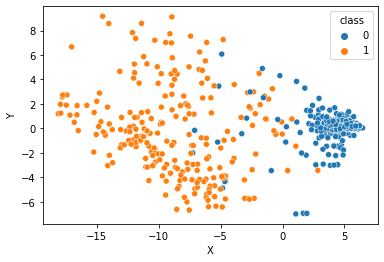

In [18]:
sns.scatterplot(x = 'X', y = 'Y', hue = 'class', data = data) #actual clusters

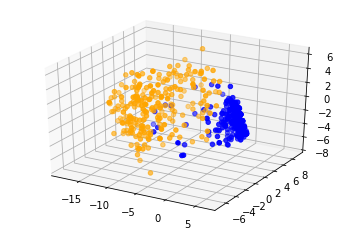

In [19]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(data['class']==1)]['X'],data[(data['class']==1)]['Y'],data[(data['class']==1)]['Z'], color='orange')
ax.scatter3D(data[(data['class']==0)]['X'],data[(data['class']==0)]['Y'],data[(data['class']==0)]['Z'], color='blue')

Here, we use PCA to plot the actual cluster assingments using the class column from dataframe data. The orange points represents malignant tumors and the blue are benign. Already, we can see two somewhat distinct clusters that we will later compare to our K-means clusters to determine the accuracy of the model. We've plotted in both 2D and 3D to get a better visualization of the multidimensional data. Later, we will run K-means plotting in both 2D and 3D, though the cluster assignments will not change.

In [20]:
#%matplotlib qt

# K-Means

In [21]:
def calcSqDistances(X, Kmus):
    N = np.shape(X)[0]
    K = Kmus.shape[0]
    D = [] #initialize to be NxK shape np.zeros()
    for point in X:
        for kpoint in Kmus:
            D.append(np.sqrt(np.sum((point - kpoint)**2)))
    D = np.array(D)
    D = D.reshape((N, K))
                     
    return D

In [22]:
def determineRnk(sqDmat):
    m,n = sqDmat.shape
    for arr in sqDmat:
        index = np.argmin(arr, axis = None, out = None)
        for i in range(n):
            if not i==index:
                arr[i] = 0
        arr[index] = 1
    return sqDmat

In [23]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk,axis=0))).T

In [24]:
def runKMeans3D(K, data):
    X = data.to_numpy()
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    Kmus = np.zeros((K, D))
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];
    maxiters = 1000;
    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus);
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus
    ##        
        clus = Rnk.T[0]
        clus = clus.astype('int')
        
        data['Rnk'] = clus
        Kmus = recalcMus(X, Rnk)
        
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(data[(data['Rnk']==1)]['X'],data[(data['Rnk']==1)]['Y'],data[(data['Rnk']==1)]['Z'], color='orange')
        ax.scatter3D(data[(data['Rnk']==0)]['X'],data[(data['Rnk']==0)]['Y'],data[(data['Rnk']==0)]['Z'], color='blue')

        plt.show()
    ##        
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break   
        
    return Rnk

In [25]:
def runKMeans(K, data):
    X = data.to_numpy()
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    Kmus = np.zeros((K, D))
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];
    maxiters = 1000;
    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus);
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus 
        clus = Rnk.T[0]
        clus = clus.astype('int')
        data['Rnk'] = clus
        Kmus = recalcMus(X, Rnk)
        if Kmus.shape[1] > 2:
            c = np.dot(U.T, Kmus[:,0:9].T-mean)
        sns.scatterplot(x = 'X', y = 'Y', hue = 'Rnk', data = data)
        if Kmus.shape[1] > 2:
            plt.scatter(c[0],c[1],marker='x',color='k',s=80)
        else:
            plt.scatter(Kmus[0][0],Kmus[0][1],marker='x',color='k',s=80) #plotting mean center for cluster 1
            plt.scatter(Kmus[1][0],Kmus[1][1],marker='x',color='k',s=80) #plotting mean center for cluster 2
        plt.show()
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break               
    return Rnk

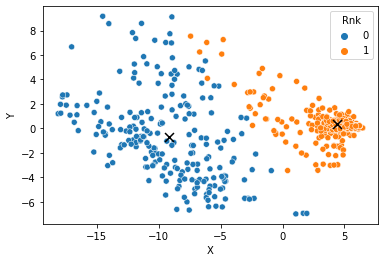

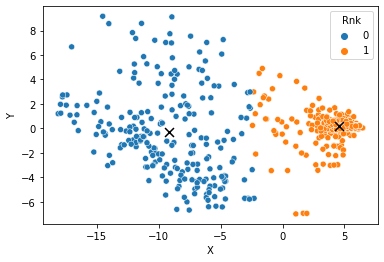

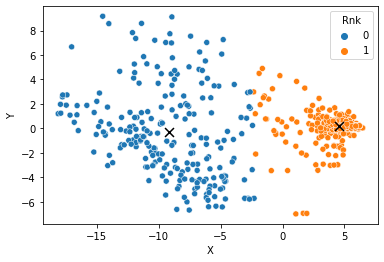

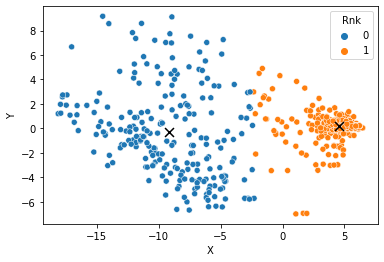

In [26]:
U.shape
IID_Rnk = runKMeans(2, df)

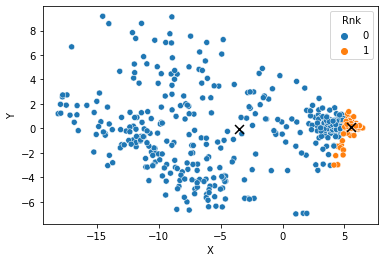

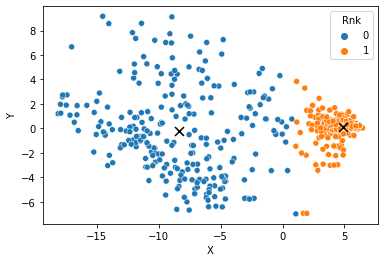

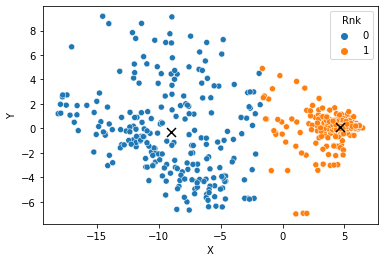

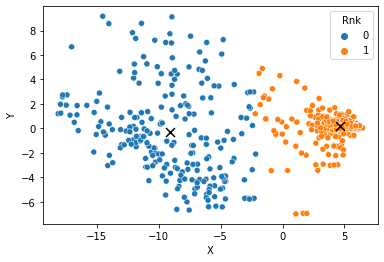

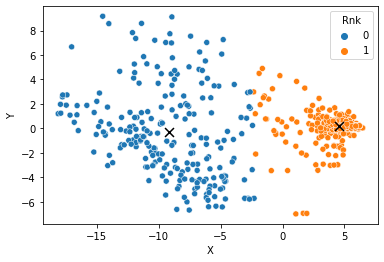

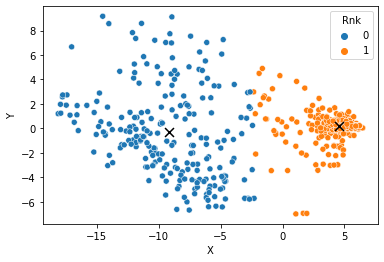

In [27]:
a = df.iloc[:,9:11] #k means on the PCA data compared to 
IID_PCA_Rnk = runKMeans(2, a)

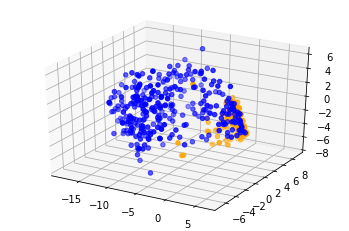

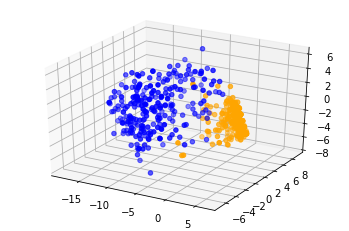

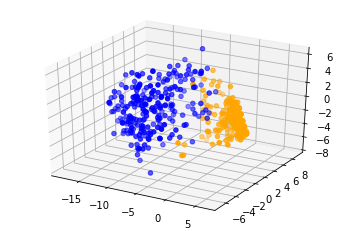

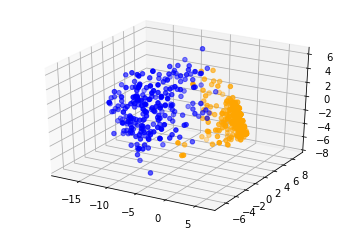

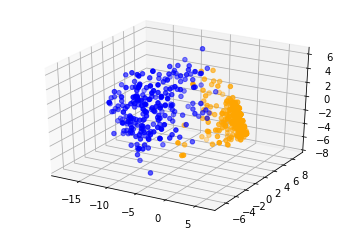

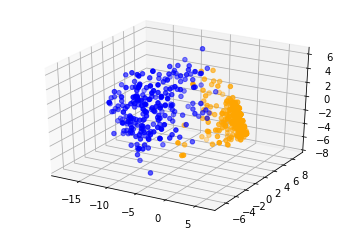

In [28]:
IIID_Rnk = runKMeans3D(2,df)

# Gaussian Mixture Models

tied pca matches: 669
tied raw matches: 658
full pca matches: 669
full raw matches: 610
diag pca matches: 669
diag raw matches: 652
spherical pca matches: 671
spherical raw matches: 657


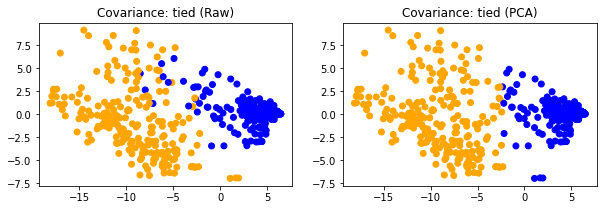

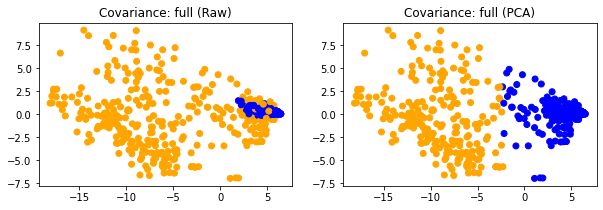

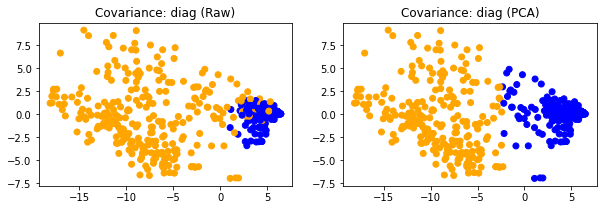

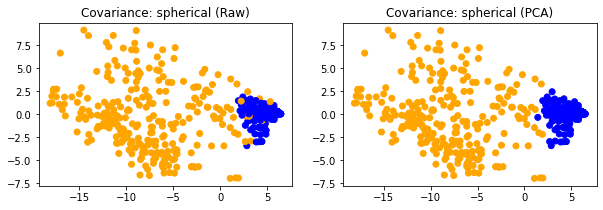

In [63]:
rawX = df.iloc[:, :9]           # Raw data columns
pcaX = df.iloc[:, 9:-1]         # PCA data columns

covTypes = ['tied', 'full', 'diag', 'spherical']        # Different covariance types
# 'full' (each component has its own general covariance matrix),
# 'tied' (all components share the same general covariance matrix),
# 'diag' (each component has its own diagonal covariance matrix),
# 'spherical' (each component has its own single variance).

for cov in covTypes:
    gmmRaw = mixture.GaussianMixture(n_components=2, covariance_type=cov).fit(rawX)
    labelRaw = gmmRaw.predict(rawX)     # Prediction for Raw data
    gmmPCA = mixture.GaussianMixture(n_components=2, covariance_type=cov).fit(pcaX)
    labelPCA = gmmPCA.predict(pcaX)     # Prediction for PCA data

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)
    colors = {0: 'blue', 1: 'orange'}
    ax1.scatter(df['X'], df['Y'], c=[colors[i] for i in labelRaw])
    ax1.set_title('Covariance: '+cov+' (Raw)')
    ax2.scatter(df['X'], df['Y'], c=[colors[i] for i in labelPCA])
    ax2.set_title('Covariance: '+cov+' (PCA)')
    print(cov, 'pca matches:', sum(data['class']==labelPCA))
    print(cov, 'raw matches:', sum(data['class']==labelRaw))

# Covariance Type 'spherical' best! Save into df as 'gmmRaw' and 'gmmPCA' columns
df['gmmRaw'] = labelRaw
df['gmmPCA'] = labelPCA

In [39]:
df

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,X,Y,Z,Rnk,gmmRaw,gmmPCA
0,5,1,1,1,2,1,3,1,1,4.437523,0.140152,1.739688,1,0,0
1,5,4,4,5,7,10,3,2,1,-4.842940,-4.875919,-0.861617,0,1,1
2,3,1,1,1,2,2,3,1,1,4.594002,-0.603916,-0.027812,1,0,0
3,6,8,8,1,3,4,3,7,1,-5.145849,3.458943,2.032486,0,1,1
4,4,1,1,3,2,1,3,1,1,4.072230,-0.037962,-0.055371,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,4.928586,-0.445218,0.130176,1,0,0
695,2,1,1,1,2,1,1,1,1,5.916401,0.197057,-0.606264,1,0,0
696,5,10,10,3,7,3,8,10,2,-10.319805,7.208938,-0.794679,0,1,1
697,4,8,6,4,3,4,10,6,1,-6.449759,2.488778,-1.817876,0,1,1


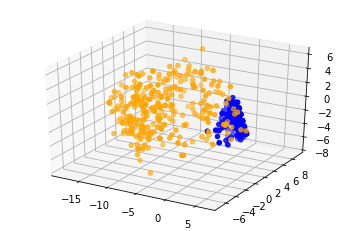

In [40]:
# 3D GMM - Raw data
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(df['gmmRaw']==1)]['X'],df[(df['gmmRaw']==1)]['Y'],df[(df['gmmRaw']==1)]['Z'], color='orange')
ax.scatter3D(data[(df['gmmRaw']==0)]['X'],df[(df['gmmRaw']==0)]['Y'],df[(df['gmmRaw']==0)]['Z'], color='blue')

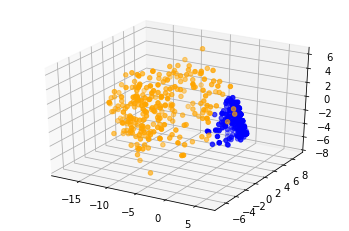

In [41]:
# 3D GMM - PCA data
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(df['gmmPCA']==1)]['X'],df[(df['gmmPCA']==1)]['Y'],df[(df['gmmPCA']==1)]['Z'], color='orange')
ax.scatter3D(data[(df['gmmPCA']==0)]['X'],df[(df['gmmPCA']==0)]['Y'],df[(df['gmmPCA']==0)]['Z'], color='blue')

Actual cluster assingments

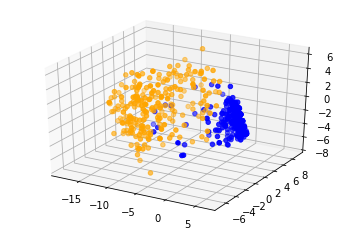

In [42]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(data['class']==1)]['X'],data[(data['class']==1)]['Y'],data[(data['class']==1)]['Z'], color='orange')
ax.scatter3D(data[(data['class']==0)]['X'],data[(data['class']==0)]['Y'],data[(data['class']==0)]['Z'], color='blue')

Predicted cluster assingments

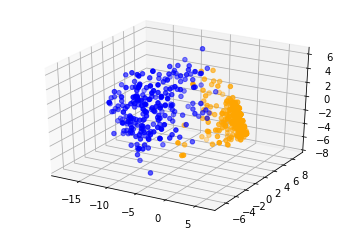

In [ ]:
#%matplotlib qt
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(df['Rnk']==1)]['X'],df[(df['Rnk']==1)]['Y'],df[(df['Rnk']==1)]['Z'], color='orange')
ax.scatter3D(data[(df['Rnk']==0)]['X'],df[(df['Rnk']==0)]['Y'],df[(df['Rnk']==0)]['Z'], color='blue')

plt.show()

<b>IMPORTANT</b> For anyone running this notebook, the code below will create interactable 3D plots of the actual cluster assignments and predicted cluster assignments. Skip these cells if you don't want to have plots keep popping out in new windows.

# Model Accuracy

In [43]:
# Model Accuracy for GMM
print('GMM (Raw) Accuracy:', sum(data['class']==df['gmmRaw']))
print('GMM (PCA) Accuracy:', sum(data['class']==df['gmmPCA']))

GMM (Raw) Accuracy: 657
GMM (PCA) Accuracy: 671


In [44]:
sum(data['class']==IID_Rnk.T[0]) #3D k means

30

In [45]:
sum(data['class']==IID_PCA_Rnk.T[0])

30

In [46]:
sum(data['class']==IIID_Rnk.T[0]) #3D k means

30

We had the exact same values when running K-means on PCA data and the original 9-dimensional data so we will only be computing one confusion matrix to measure our model's accuracy.

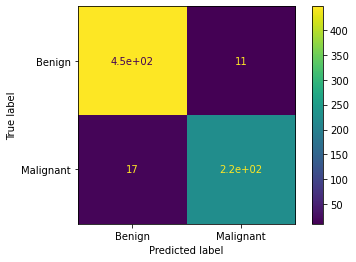

In [ ]:
# K-Means
y_true = data['class']
y_pred = df['Rnk']
np.array(confusion_matrix(y_true, y_pred).ravel()).reshape(2,2)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),display_labels=['Benign','Malignant'])
disp.plot() 

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
print("True Malignant Rate: ",TPR)
print("True Benign Rate: ", TNR)
TR = (tp+tn)/(tn+fn+tp+fp)
print("True Total Rate: ",TR)

True Malignant Rate:  0.9294605809128631
True Benign Rate:  0.9759825327510917
True Total Rate:  0.9599427753934192


Overall, K-Means model seems to be about 95.7% accurate. It seems to be more accurate when it comes to predicting benign than malignant tumors. This could be atributed to the way that the benign tumor datapoints have a much denser and closer cluster than the malignant tumor datapoints, most likely due to the nature of malignant tumors (not having consistent characteristics). Additionally, our data had more benign tumors which may have also affected prediction capability.

True Malignant Rate:  0.995850622406639
True Benign Rate:  0.9104803493449781
True Total Rate:  0.9399141630901288


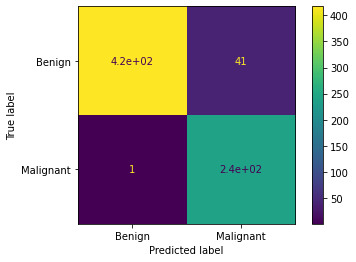

In [47]:
# Gaussian Mixture Models - Raw
y_true = data['class']
yRaw = df['gmmRaw']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, yRaw),display_labels=['Benign','Malignant'])
disp.plot() 

tn, fp, fn, tp = confusion_matrix(y_true, yRaw).ravel()
TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
print("True Malignant Rate: ",TPR)
print("True Benign Rate: ", TNR)
TR = (tp+tn)/(tn+fn+tp+fp)
print("True Total Rate: ",TR)

True Malignant Rate:  0.995850622406639
True Benign Rate:  0.9410480349344978
True Total Rate:  0.9599427753934192


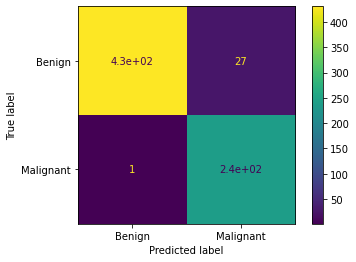

In [48]:
# Gaussian Mixture Models - PCA
y_true = data['class']
yPCA = df['gmmPCA']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, yPCA),display_labels=['Benign','Malignant'])
disp.plot() 

tn, fp, fn, tp = confusion_matrix(y_true, yPCA).ravel()
TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
print("True Malignant Rate: ",TPR)
print("True Benign Rate: ", TNR)
TR = (tp+tn)/(tn+fn+tp+fp)
print("True Total Rate: ",TR)